# Grad-CAMの実装

COVID-19を含む胸部X線写真の分類をするモデル CoroNet を利用し，その判断基準を可視化するGrad-CAMを適用する。

In [28]:
!pip -q install torchxrayvision==0.0.39 torchinfo
!git clone https://github.com/ieee8023/covid-chestxray-dataset
!git clone https://github.com/chirag126/CoroNet.git

import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch.utils.data import random_split, DataLoader
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from typing import Optional, List
from pprint import pprint

import torchinfo
import torchxrayvision as xrv
from CoroNet.FPAE import FPN_Gray

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fix_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_seed(42)

/bin/bash: /home/bdr/anaconda3/envs/deep/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/bdr/anaconda3/envs/deep/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.
/bin/bash: /home/bdr/anaconda3/envs/deep/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
fatal: destination path 'CoroNet' already exists and is not an empty directory.


型ヒントについて

- Pythonは動的型付け言語のため型を指定して変数を定義する必要はないが，関数の入出力にこれを書いておくことで，自分を含め人が読みやすいコードにすることができる

- 注意点として，Pythonではこれはあくまでヒントに過ぎないので，もし**型ヒントに書いたものと違う型の値を入力してもエラーは出ない**．

- 以下によく使う`typing`モジュールのAPI

  - `Union`: 複数の型があり得る（e.g. `Union[int, float]`の場合，`int`と`float`があり得る）
  - `Optional`: `None`があり得る（e.g. `Optional[int]`は`Union[int, None]`と同等）
  - `Callable`: 関数であることを示す
  - さらに，`List`, `Dict`, `Tuple`など，本来Pythonにある型を示すためのAPIもある



## 1. データセットの読み込み

[covid-chestxray-dataset](は，胸部X線写真を，COVID-19を含む23クラスの病理でラベル付けした小規模な公開データセット

また，[torchxrayvision]というX線写真関連のデータセットやモデルを扱うライブラリ（`xrv`というエイリアスでインポート）を用い，ダウンロードしたデータセットを整形し読み込む

In [29]:
transform = torchvision.transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(224),
    # 読み込まれる胸部X線写真の各ピクセルの値の範囲は[-1024, 1024]なので[0, 1]に変換する。
    transforms.Lambda(lambda x: (x + 1024) / 2048),
])

dataset = xrv.datasets.COVID19_Dataset(
    imgpath="covid-chestxray-dataset/images/",
    csvpath="covid-chestxray-dataset/metadata.csv",
    views=["PA"],
    unique_patients=True,
    transform=transform,
)
DATASET_CLASS_LIST = dataset.pathologies

pprint(dataset)

Setting XRayResizer engine to cv2 could increase performance.
{'Aspergillosis': {0.0: 331, 1.0: 1},
 'Bacterial': {0.0: 297, 1.0: 35},
 'COVID-19': {0.0: 136, 1.0: 196},
 'Chlamydophila': {0.0: 331, 1.0: 1},
 'Fungal': {0.0: 310, 1.0: 22},
 'H1N1': {0.0: 331, 1.0: 1},
 'Influenza': {0.0: 330, 1.0: 2},
 'Klebsiella': {0.0: 325, 1.0: 7},
 'Legionella': {0.0: 328, 1.0: 4},
 'Lipoid': {0.0: 328, 1.0: 4},
 'MERS-CoV': {0.0: 328, 1.0: 4},
 'MRSA': {0.0: 331, 1.0: 1},
 'Mycoplasma': {0.0: 328, 1.0: 4},
 'No Finding': {0.0: 322, 1.0: 10},
 'Nocardia': {0.0: 328, 1.0: 4},
 'Pneumocystis': {0.0: 311, 1.0: 21},
 'Pneumonia': {0.0: 19, 1.0: 313},
 'SARS': {0.0: 324, 1.0: 8},
 'Staphylococcus': {0.0: 331, 1.0: 1},
 'Streptococcus': {0.0: 320, 1.0: 12},
 'Tuberculosis': {0.0: 323, 1.0: 9},
 'Varicella': {0.0: 328, 1.0: 4},
 'Viral': {0.0: 118, 1.0: 214}}
COVID19_Dataset num_samples=332 views=['PA'] data_aug=None


データローダーを用意し，ランダムに16サンプル可視化

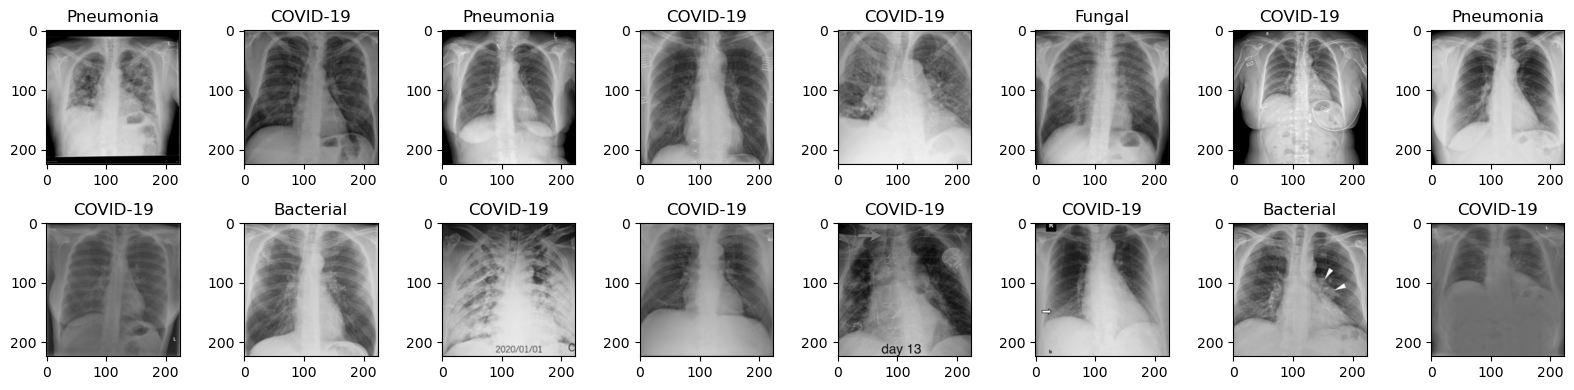

In [30]:
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
)

batch = next(iter(dataloader))
image, target = batch['img'], batch['lab']

fig, axes = plt.subplots(2, 8, figsize=(16, 4), tight_layout=True)

axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(image[i].permute(1, 2, 0).repeat(1, 1, 3), cmap='gray')
    ax.set_title(DATASET_CLASS_LIST[target[i].argmax().item()])

## 2. 学習済みモデルの作成

CoroNetは，オートエンコーダーとResNetを組み合わせ，胸部X線写真を正常 / COVID-19 / non COVID-19肺炎の3クラスに分類するDNNモデル

- データセットは23クラスですが，COVID-19以外をnon-COVID19とまとめて扱う

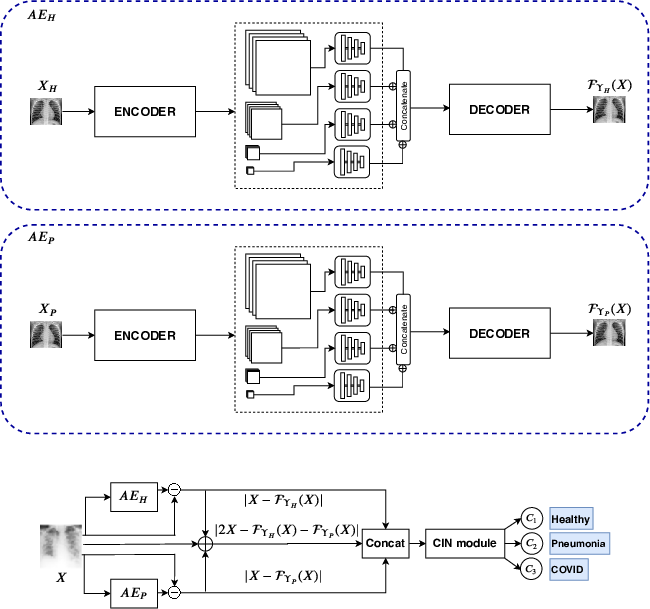

In [31]:
class CoroNet(nn.Module):

    def __init__(
        self,
        ae_0_weights_path: str='./CoroNet/weights/label_0_best.pth',
        ae_1_weights_path: str='./CoroNet/weights/label_1_best.pth',
        classifier_weights_path: str='./CoroNet/weights/classifier_best.pth'
    ) -> None:
        super().__init__()

        # 1つめのオートエンコーダ AE_H
        self.model_1 = FPN_Gray() # Feature Pyramid Network
        self.model_1.load_state_dict(
            torch.load(ae_0_weights_path, map_location=torch.device(device))
        )

        # 2つめのオートエンコーダ AE_P
        self.model_2 = FPN_Gray()
        self.model_2.load_state_dict(
            torch.load(ae_1_weights_path, map_location=torch.device(device))
        )

        self.classifier = torchvision.models.resnet18()
        num_ftrs = self.classifier.fc.in_features
        # 3クラス分類
        self.classifier.fc = nn.Linear(num_ftrs, 3)
        self.classifier.load_state_dict(
            torch.load(classifier_weights_path, map_location=torch.device(device))
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # 今回は最終Conv層までbackpropできれば良いので，オートエンコーダ部分では
        # 勾配の計算を無効化します．これによりGPUメモリを節約できます．
        with torch.no_grad():
            output_1, org, z = self.model_1(X)
            output_2, org, z = self.model_2(X)

        # 元の入力と2つのAEの出力から計算した特徴量をconcatして，ResNetに入力
        pred = self.classifier(
            torch.cat((
                torch.abs(org - output_1),
                torch.abs(org - output_2),
                torch.abs(2 * org - output_1 - output_2)),
            dim=1)
        )
        return pred

In [32]:
MODEL_CLASS_LIST = ['Healthy', 'non-COVID Pneumonia', 'COVID-19']
NUM_CLASSES = len(MODEL_CLASS_LIST)

network = CoroNet().to(device).eval()
image = image.to(device)
network(image)

tensor([[-4.1325,  1.2821,  2.6353],
        [-7.3202, -4.7182,  8.5976],
        [ 0.8365, -0.9154, -1.0625],
        [-6.6840, -3.4406,  7.4184],
        [-7.6635, -2.1152,  7.6608],
        [-5.5972, -3.9652,  6.5353],
        [-0.1531, -2.5751,  1.3678],
        [ 0.6859, -2.7515,  0.4884],
        [ 0.3632, -1.0366, -0.4724],
        [ 0.4723, -2.0637,  0.6117],
        [-5.0716,  1.4352,  3.3104],
        [-2.4235, -2.3302,  2.9326],
        [-3.5438,  1.9941,  1.5510],
        [-6.0914, -4.1431,  7.1699],
        [-5.6060, -5.0940,  7.3410],
        [ 1.5060,  0.1712, -2.4625]], grad_fn=<AddmmBackward0>)

[torchinfo](https://github.com/TylerYep/torchinfo)を用いて各レイヤーの出力の形状などを可視化

In [33]:
torchinfo.summary(
    network,
    input_size=image.shape,
    depth=2,
)

Layer (type:depth-idx)                        Output Shape              Param #
CoroNet                                       [16, 3]                   --
├─FPN_Gray: 1-1                               [16, 1, 224, 224]         --
│    └─BatchNorm2d: 2-1                       [16, 1, 224, 224]         2
│    └─Conv2d: 2-2                            [16, 8, 224, 224]         80
│    └─ReLU: 2-3                              [16, 8, 224, 224]         --
│    └─BatchNorm2d: 2-4                       [16, 8, 224, 224]         16
│    └─Conv2d: 2-5                            [16, 16, 224, 224]        1,168
│    └─ReLU: 2-6                              [16, 16, 224, 224]        --
│    └─BatchNorm2d: 2-7                       [16, 16, 224, 224]        32
│    └─Conv2d: 2-8                            [16, 32, 224, 224]        4,640
│    └─ReLU: 2-9                              [16, 32, 224, 224]        --
│    └─BatchNorm2d: 2-10                      [16, 32, 224, 224]        64
│    └─Conv2d: 

## 3. Grad-CAMクラスの実装

Grad-CAM (#scrollTo=l1GhWf5vYPVl) は，Gradients(#scrollTo=l1GhWf5vYPVl) の考え方をCAM (#scrollTo=l1GhWf5vYPVl) に組み合わせることで改良したもの

CAMでは，Global Average Pooling (GAP)層から出力ユニットに接続するエッジの重みでfeature mapの加重平均を取っていたが
Grad-CAMでは，それをfeature mapの勾配の平均に置き換えることで，GAPのないモデルにも適用できるようなった

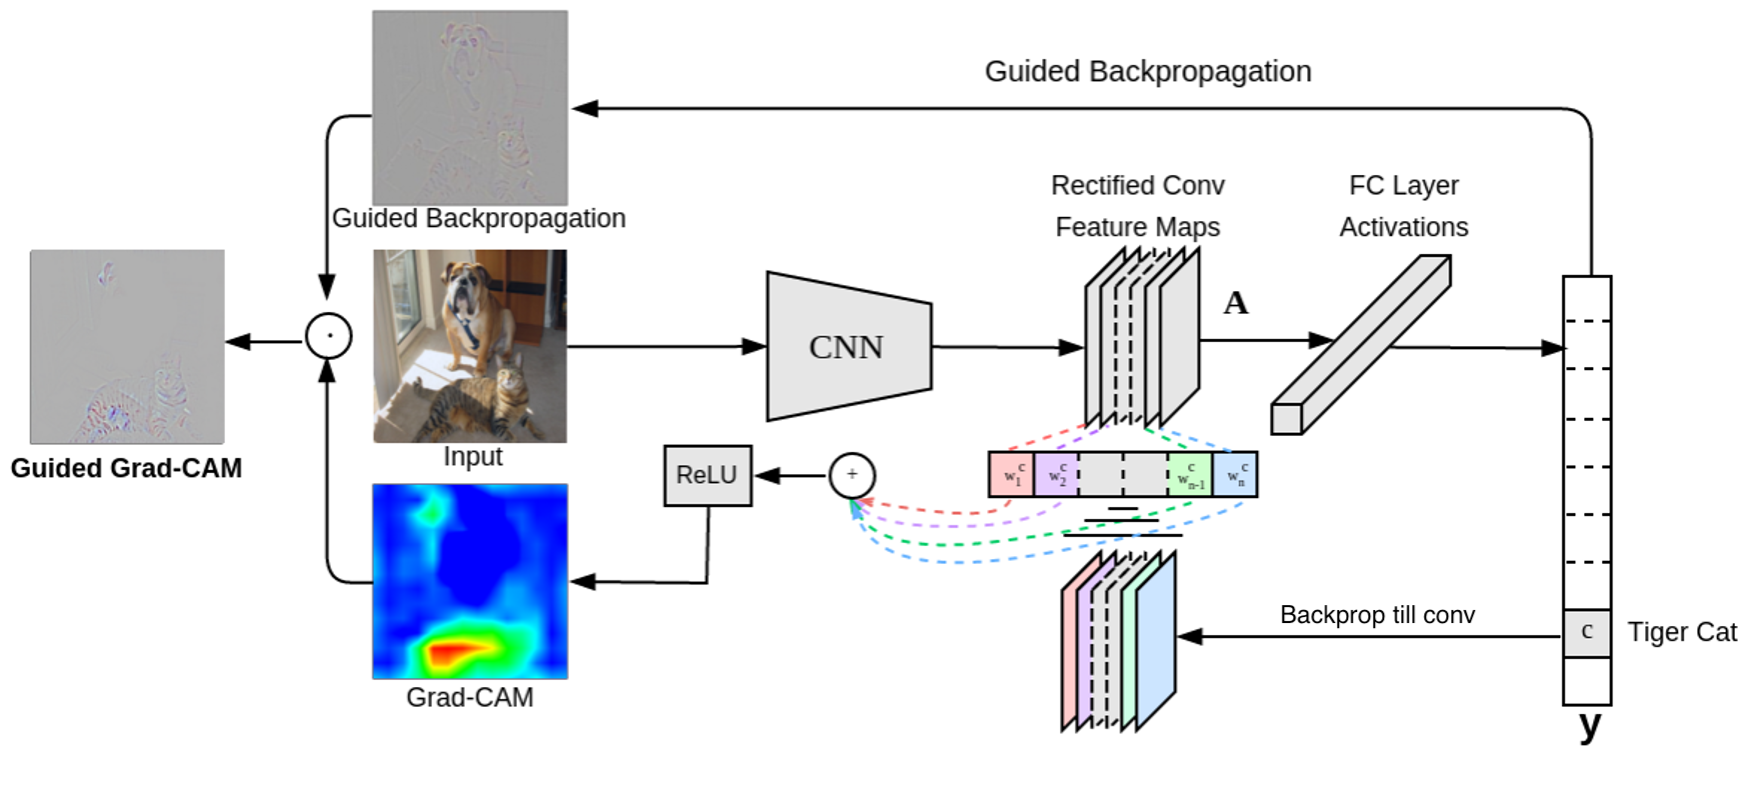

モデルとその特定のレイヤーを指定することで，入力に対するGrad-CAMを出力するクラスを作成

- `nn.Module`の[register_forward_hook()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook) / [register_backward_hook()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_backward_hook)によって，順伝播時 / 逆伝播時に呼びたい関数の登録ができる。
  - 今回の場合，順伝播時に`self._save_target_layer_feature_map`を呼んでfeature mapを保存し，逆伝播時に`self._save_target_layer_grad`を呼んでfeature mapの勾配を保存

- 今回Guided Backpropagationの可視化は行なっていない

In [34]:
class SimpleGradCAM:

    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        for param in model.parameters():
            param.requires_grad = True
        self.model.eval()
        self.target_layer_feature_map = None
        self.target_layer_grad_list = []
        self.hook_list = []
        self.hook_list.append(
            # 順伝播時に，feature mapを取り出して保存する．
            self.target_layer.register_forward_hook(self._save_target_layer_feature_map)
        )
        self.hook_list.append(
            # 逆伝播時に，feature mapの勾配を取り出して保存する．
            self.target_layer.register_backward_hook(self._save_target_layer_grad)
        )

    def _save_target_layer_feature_map(self, module, input, output):
        self.target_layer_feature_map = output.clone()

    def _save_target_layer_grad(self, module, input_grad, output_grad):
        self.target_layer_grad_list.append(output_grad[0].clone())

    # インスタンスを関数のように呼ぶと，__call__()が呼ばれる．
    def __call__(
        self,
        x: torch.Tensor,
        target_category: Optional[int] = None
    ) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): ( batch_size, C, H, W )
        """
        batch_size = x.shape[0]

        self.target_layer_feature_map_list = []
        self.target_layer_grad_list = []

        # forwardが実行され，self.target_layer_feature_mapにfeature mapが保存される．
        output = self.model(x)

        # batch内の画像ごとに，モデルの出力の勾配を計算する．
        for n in range(batch_size):
            # target_categoryを指定しなければ，モデルの判断したクラスで計算
            idx = output[n].argmax() if target_category is None else target_category

            output_n = output[n, idx]

            self.model.zero_grad()

            # self.target_layer_grad_listに各画像ごとのfeature mapの勾配がappendされる．
            # ロスではなくモデル出力でのbackwardであることに注意
            output_n.backward(retain_graph=True)

        # feature mapの勾配を結合する．
        self.target_layer_grad = torch.stack(
            [grad[i] for i, grad in enumerate(self.target_layer_grad_list)],
            dim=0
        ) # ( batch_size, channels, kernel_size, kernel_size )

        # feature mapの勾配を，画像およびchannel毎に平均する (Global Average Pooling)．
        self.target_layer_weight = torch.mean(self.target_layer_grad, dim=(2, 3))
        # ( batch_size, channels )

        # feature mapをfeature mapの勾配のGAPで重み付けした平均を計算する．
        # 図示する際に画像毎に正規化するので，ここで重みの正規化はしない（しても良い）．
        # torch.mulは要素積を計算するものです．ここではkernel_size方向にブロードキャストさせています．
        self.target_layer_weighted_feature_map = torch.mul(
            self.target_layer_weight[:, :, None, None], # ( batch_size, channels, 1, 1 )
            self.target_layer_feature_map # ( batch_size, channels, kernel_size, kernel_size )
        )

        # 最後にReLUを通す。
        self.target_layer_heatmap = nn.functional.relu(
            torch.sum(self.target_layer_weighted_feature_map, dim=1, keepdim=True)
        )

        return self.target_layer_heatmap, output.argmax(dim=1)

    def clear_hook(self) -> None:
        for hook in self.hook_list:
            hook.remove()

## 4. Grad-CAMの実行

CoroNetのclassifierの最後の畳込みレイヤーにGrad-CAMを適用

In [35]:
target_layer = network.classifier.layer4[1].conv2  # 最終畳み込みレイヤー

他のレイヤーにGrad-CAMを適用したい場合は，`named_modules`で確認して変更

In [36]:
network.named_modules

<bound method Module.named_modules of CoroNet(
  (model_1): FPN_Gray(
    (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(24, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [37]:
gradcam = SimpleGradCAM(network, target_layer)

# target_categoryを指定せず，モデルの出力クラスについて可視化します．
heatmap, preds = gradcam(image.to(device))

gradcam.clear_hook()

print(f"GPU memory used: {torch.cuda.memory_allocated() * 1e-9} GB")

GPU memory used: 0.0 GB


元画像にheatmapを重ねるための便利関数を定義

In [38]:
def make_grid_heatmap_on_image(
    image_tensor: torch.Tensor,
    heatmap_tensor: torch.Tensor,
    intensity: float,
    nrow: int,
    padding: int,
    image_normalize_value_range: Optional[tuple] = None,
    heatmap_normalize_value_range: Optional[tuple] = None,
    image_preprocess_fn=None,
    heatmap_preprocess_fn=None
) -> List[np.ndarray]:

    def _add_heatmap_on_image(image: np.ndarray, heatmap: np.ndarray, intensity: float) -> np.ndarray:

        color_heatmap = np.uint8(heatmap * 255)
        color_heatmap = np.uint8(cv2.applyColorMap(color_heatmap, cv2.COLORMAP_JET))
        color_heatmap = cv2.cvtColor(color_heatmap, cv2.COLOR_BGR2RGB)

        heatmap_on_image = np.uint8(image * 255)
        heatmap_on_image = cv2.addWeighted(color_heatmap, intensity, heatmap_on_image, 1, 0)

        return heatmap_on_image

    if image_preprocess_fn is not None:
        image_tensor = image_preprocess_fn(image_tensor)

    grid_image = make_grid(
        image_tensor.cpu(),
        normalize=True if image_normalize_value_range else False,
        value_range=image_normalize_value_range if image_normalize_value_range else None,
        nrow=nrow,
        padding=padding
    ).permute(1, 2, 0).cpu().numpy()

    N, C, H, W = image_tensor.shape

    if heatmap_preprocess_fn is not None:
        heatmap_tensor = heatmap_preprocess_fn(heatmap_tensor)

    grid_heatmap = make_grid(
        transforms.Resize((H, W))(heatmap_tensor).cpu(),
        normalize=True if heatmap_normalize_value_range else False,
        value_range=heatmap_normalize_value_range if heatmap_normalize_value_range else None,
        nrow=nrow,
        padding=padding
    ).permute(1, 2, 0).cpu().numpy()

    return grid_image, grid_heatmap, _add_heatmap_on_image(grid_image, grid_heatmap, intensity)


def _scale_min_max_per_channel(tensor: torch.Tensor) -> torch.Tensor:

    def _calc_min_max_per_channel(tensor: torch.Tensor) -> List[torch.Tensor]:
        min_ = tensor.min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0]
        max_ = tensor.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0]

        return min_, max_

    min_, max_ = _calc_min_max_per_channel(tensor)

    return (tensor - min_) / (max_ - min_)

Model predictions: ['COVID-19', 'COVID-19', 'Healthy', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'Healthy', 'Healthy', 'COVID-19', 'COVID-19', 'COVID-19', 'non-COVID Pneumonia', 'COVID-19', 'COVID-19', 'Healthy']


Text(0.5, 1.0, 'Chest X-ray with Grad-CAM')

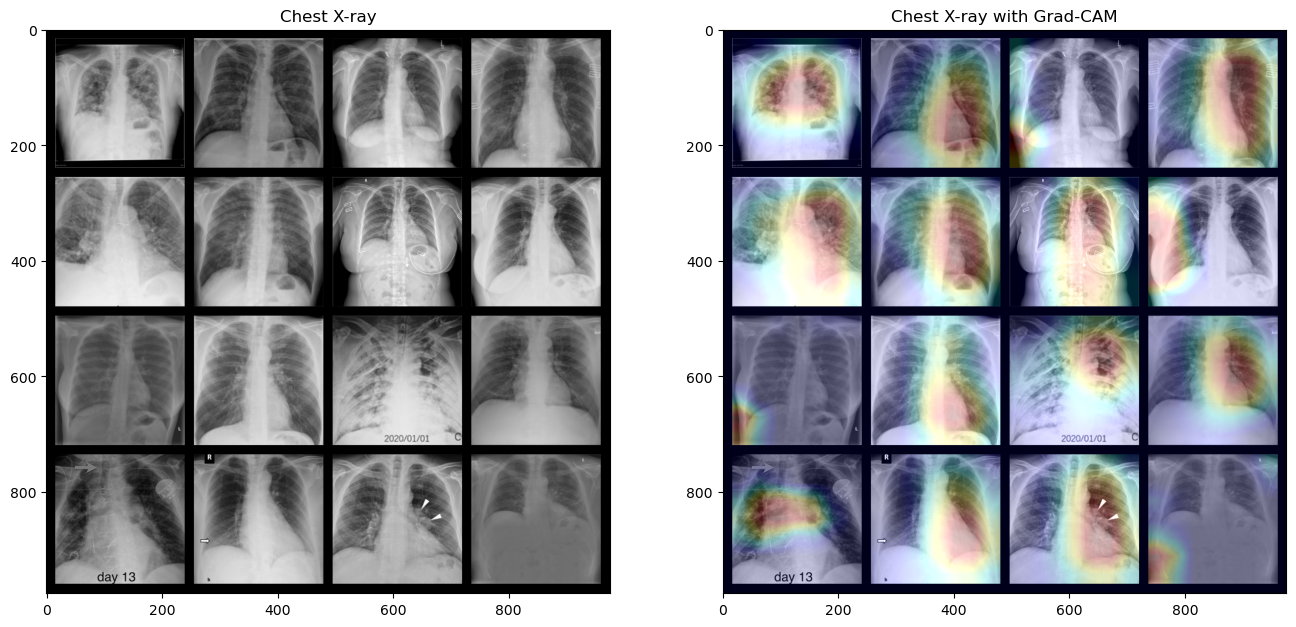

In [39]:
print(f"Model predictions: {[MODEL_CLASS_LIST[p] for p in preds]}")

grid_image, _, grid_heatmap_on_image = make_grid_heatmap_on_image(
    image,
    heatmap,
    0.2,
    nrow=4,
    padding=16,
    # image_normalize_value_range=(-1024, 1024),
    heatmap_preprocess_fn=_scale_min_max_per_channel
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(grid_image, cmap="gray")
ax[0].set_title('Chest X-ray')

ax[1].imshow(grid_heatmap_on_image)
ax[1].set_title('Chest X-ray with Grad-CAM')